In [11]:
%load_ext autoreload
%autoreload 2

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Image Matching Challenge (PhotoTourism)

In [18]:
from imc.imc_benchmark_utils import load_imc_results

res_path = "imc/image-matching-benchmark/packed-test"

results = load_imc_results(res_path, return_df=True, all_scenes=False, auc_th=5)
results

,method,kpts_budget,params,all_rep,all_inliers,all_auc5
0,superpoint,2048kpts,matcher-mnn0.0-ransac-0.5,36.1,112.0,17.9


## HPatches

In [13]:
from benchmark_utils import display_hpatches_results

print("===== HPatches Overall Results =====")
display_hpatches_results(partition='overall', ths=[1, 2, 3], tostring=False)  # Display results for thresholds 1, 2, and 3

===== HPatches Overall Results =====


,Method,Rep@1,Rep@2,Rep@3,MA@1,MA@2,MA@3,MS@1,MS@2,MS@3,HA@1,HA@2,HA@3
0,aliked,29.0,48.0,57.6,40.4,64.3,74.6,26.3,40.9,46.9,39.3,65.0,77.6
1,aliked+SANDesc,29.0,48.0,57.6,45.0,72.3,83.0,26.7,41.1,46.5,43.7,65.0,77.6
2,dedode,31.6,45.7,54.2,50.1,70.3,78.5,22.2,30.1,33.3,48.0,70.0,78.0
3,dedode+SANDesc,31.6,45.7,54.2,52.3,72.7,80.6,22.5,30.3,33.2,48.9,71.9,78.1
4,dedode-G,31.5,45.9,54.3,48.4,68.6,77.0,22.4,30.8,34.2,48.0,69.8,79.1
5,disk,29.2,44.3,52.7,45.6,67.5,76.7,27.7,39.8,44.7,39.8,61.7,72.8
6,disk+SANDesc,29.2,44.3,52.7,49.0,73.4,84.0,27.7,39.9,45.0,40.4,62.6,73.5
7,ripe,26.8,42.0,50.8,41.3,63.3,73.3,25.3,37.8,43.3,44.3,68.1,79.3
8,ripe+SANDesc,26.8,42.0,50.8,45.6,70.9,82.4,25.2,37.5,42.9,42.2,68.1,77.8
9,superpoint,22.8,40.4,52.3,30.4,50.8,62.4,19.0,31.5,38.3,35.4,63.1,75.0


## Megadepth-1500

In [14]:
import pandas as pd

results = 'megadepth1500/results/results.json'
if not os.path.exists(results):
    raise FileNotFoundError(f"Results file not found: {results}. First run the benchmark!")

df = pd.read_json(results).T.round(3)
df['inlier'] = round(df['inlier']).astype(int)
df['auc_5'] *= 100
df['auc_10'] *= 100
df['model'] = df.index.str.split(' ').str[0]
df['params'] = df.index.str.split(' ').str[1]
df['budget'] = df.index.str.split(' ').str[2]
df['note'] = df.index.str.split(' ').str[3]
df['timestamp'] = df.index.str.split(' ').str[-1]

# # filter
# df = df[
#     df['model'].str.contains('dedode') 
#     & ~df['note'].str.contains('None')
# ] # comment to display all budgets 

df = df[['model',  'budget', 'inlier', 'auc_5', 'auc_10', 'note', 'timestamp']]
df.sort_values(by=['budget', 'model'], inplace=True, ascending=[True, True])
df.index = range(1, 1+len(df.index))
df

,model,budget,inlier,auc_5,auc_10,note,timestamp
1,dedode+SANDesc,2048,273,43.7,60.6,8191,20250913_102551
2,dedode+SANDesc,2048,277,44.8,61.5,9215,20250913_102832
3,dedode+SANDesc,2048,274,43.7,60.7,10239,20250913_103112
4,dedode+SANDesc,2048,273,44.2,60.8,11263,20250913_103352
5,dedode+SANDesc,2048,279,45.3,62.0,12287,20250913_103631
...,...,...,...,...,...,...,...
57,dedode+SANDesc,2048,281,46.6,62.4,65536,20250914_110909
58,dedode+SANDesc,2048,279,44.6,61.7,66560,20250914_111142
59,dedode+SANDesc,2048,280,44.6,61.7,67584,20250914_111416
60,dedode+SANDesc_paper,2048,273,45.3,61.5,None,20250913_154149


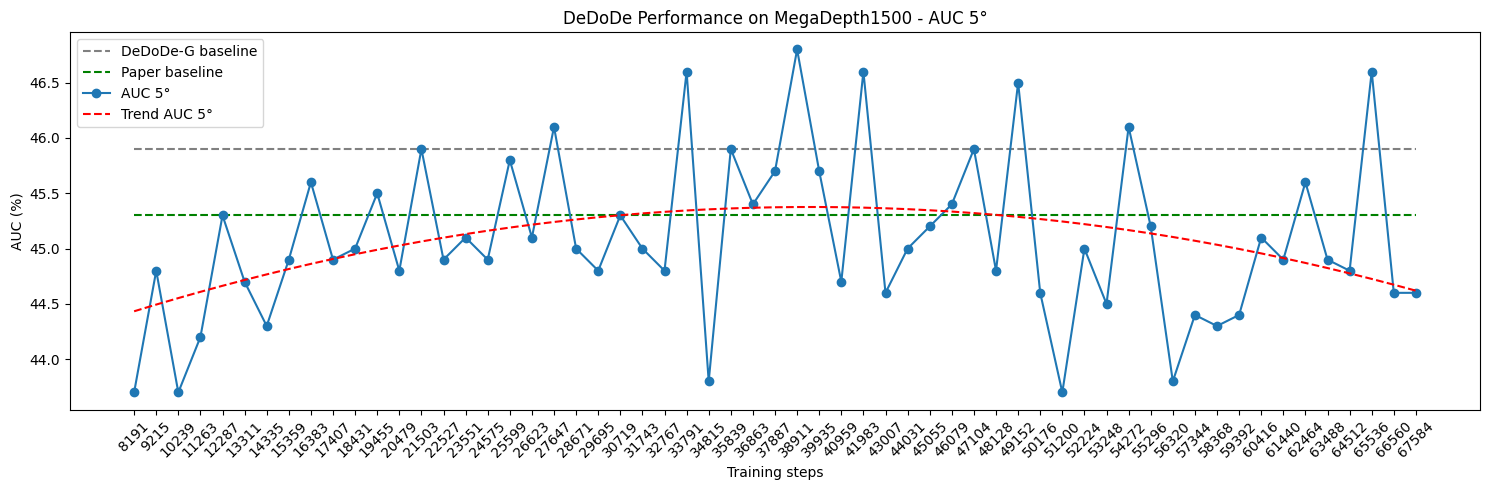

In [15]:
# plot int(note) vs metric for dedode only
import numpy as np
import matplotlib.pyplot as plt

# Specify the metric to plot: 'inlier', 'auc_5', or 'auc_10'
auc = 'auc_5'  # change to 'inlier', 'auc_5', or 'auc_10'

df_plot = df[df['model'].str.contains('dedode') & ~df['note'].str.contains('None')]
plt.figure(figsize=(15, 5))

# Check if dedode-G exists in the data
dedode_g_data = df[df['model']=='dedode-G']
if len(dedode_g_data) > 0:
    plt.hlines(y=dedode_g_data[auc].values[0], 
               xmin=df_plot['note'].astype(int).min(), 
               xmax=df_plot['note'].astype(int).max(), 
               colors='gray', linestyles='dashed', label='DeDoDe-G baseline')

# Check if 'paper' model exists in the data
paper_data = df[df['model'].str.contains('paper')]
if len(paper_data) > 0:
    plt.hlines(y=paper_data[auc].values[0], 
               xmin=df_plot['note'].astype(int).min(), 
               xmax=df_plot['note'].astype(int).max(), 
               colors='green', linestyles='dashed', label='Paper baseline')

# Dynamic label based on metric
if auc == 'inlier':
    metric_label = 'Inliers'
    ylabel = 'Number of Inliers'
elif auc == 'auc_5':
    metric_label = 'AUC 5°'
    ylabel = 'AUC (%)'
elif auc == 'auc_10':
    metric_label = 'AUC 10°'
    ylabel = 'AUC (%)'
else:
    metric_label = auc
    ylabel = 'Value'

# Main plot
plt.plot(df_plot['note'].astype(int), df_plot[auc].values, marker='o', label=metric_label)

# Estimate trend only if we have data
if len(df_plot) > 1:
    z = np.polyfit(df_plot['note'].astype(int), df_plot[auc].values, 2)
    p = np.poly1d(z)
    plt.plot(df_plot['note'].astype(int), p(df_plot['note'].astype(int)), "r--", label=f'Trend {metric_label}')

plt.xticks(df_plot['note'].astype(int).unique())
plt.legend()
plt.xlabel('Training steps')
plt.ylabel(ylabel)
plt.xticks(rotation=45)
plt.title(f'DeDoDe Performance on MegaDepth1500 - {metric_label}')
plt.tight_layout()
plt.show()

In [16]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Graz High Resolution

In [ ]:
scale_factors = {'scale_1.0': '4K', 'scale_1.5': 'QHD', 'scale_2.0': 'FHD'}

results = 'graz_high_res/results/results_paper.json'
if not os.path.exists(results):
    raise FileNotFoundError(f"Results file not found: {results}. First run the benchmark!")

df = pd.read_json(results).T.round(3)
df['inlier'] = round(df['inlier']).astype(int)
df['auc_5'] *= 100
df['auc_10'] *= 100
df['model'] = df.index.str.split(' ').str[0]
df['params'] = df.index.str.split(' ').str[1]
df['resolution'] = [scale_factors[s] for s in df.index.str.split(' ').str[2]]
df['budget'] = df.index.str.split(' ').str[3]
df['timestamp'] = df.index.str.split(' ').str[-1]

# filter
# df = df[df['resolution'].str.contains('FHD')] # comment to display all resolutions

df_auc = df[['model', 'budget', 'resolution', 'inlier', 'auc_5', 'auc_10', 'timestamp']].copy()
df_auc.sort_values(by=['resolution', 'model'], inplace=True, ascending=[False, True])
df_auc.index = range(1, 1+len(df_auc.index))
df_auc # there should be 11 elements for FHD, and 9 for QHD and 4K

,model,budget,resolution,inlier,auc_5,auc_10,timestamp
1,aliked,2048,QHD,154,51.9,65.0,20250903_123543
2,aliked+SANDesc,2048,QHD,156,64.4,75.6,20250903_131148
3,dedode+SANDesc,2048,QHD,145,56.0,69.1,20250904_010306
4,disk,2048,QHD,134,37.9,49.7,20250903_141002
5,disk+SANDesc,2048,QHD,144,54.5,67.1,20250903_144944
6,ripe,2048,QHD,109,47.5,59.9,20250903_173400
7,ripe+SANDesc,2048,QHD,117,63.2,74.7,20250903_183641
8,superpoint,2048,QHD,115,38.9,52.5,20250903_155104
9,superpoint+SANDesc,2048,QHD,161,61.7,73.8,20250903_161913
10,aliked,2048,FHD,198,54.7,67.5,20250902_113656


### Scenes breakdown

Run this after running the benchmark, otherwise no statistics are available.

In [ ]:
import json
from benchmark_utils import pose_auc

with open('graz_high_res/results/results_paper.json', 'r') as f:
    data = json.load(f)
    
keys = list(data.keys())
auc_th = 5
scale = 1 # 1, 1.5, 2

breakdown, total = {}, {}
for key in keys:
    parts = key.split(' ')
    key = f'{parts[0]}_stats_scale_{float(scale)}_{parts[4]}_{parts[6]}'
    model = parts[0]

    try:
        os.path.exists(f'graz_high_res/stats/{key}.csv')
        df = pd.read_csv(f'graz_high_res/stats/{key}.csv')
    except FileNotFoundError:
        continue

    scenes = df.scene_name.unique()
    total[model] = round(pose_auc(df.e_pose, [auc_th])[0] * 100,1)

    for scene in scenes:
        scene_df = df[df.scene_name == scene]
        if scene not in breakdown:
            breakdown[scene] = {}
        breakdown[scene][model] = round(pose_auc(scene_df.e_pose, [auc_th])[0] * 100,1)

breakdown['total'] = total

In [ ]:
df_breakdown = pd.DataFrame.from_dict(breakdown, orient='index').T
df_breakdown

,graz_main_square,graz_castle,graz_townhall,graz_university,graz_church,graz_clocktower,total
aliked,42.3,22.2,40.0,50.1,50.8,43.6,43.6
aliked+SANDesc,67.7,32.8,52.2,57.8,67.0,71.6,61.4
disk,31.0,3.2,39.4,47.2,52.0,18.8,32.8
disk+SANDesc,46.5,8.5,49.6,57.3,60.3,48.2,48.8
superpoint,28.6,19.1,25.5,28.1,29.5,43.7,32.3
superpoint+SANDesc,57.4,35.3,49.6,52.0,61.0,68.0,57.3
ripe,29.2,12.0,32.0,38.7,46.2,29.6,33.3
ripe+SANDesc,56.1,31.2,52.7,56.8,62.2,63.1,56.9
dedode+SANDesc,50.4,15.2,42.1,49.6,61.8,62.5,52.0
